In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
import random

В модела включвам всички налични данни (Общо взето овърфитвам, но дава най-добър резултат в kaggle засега). Разделям фичърите на два типа, тикива чиито стойности са числа и друг тип низове. Сливам всички данни, които са ми предоставени train + test, за да може енкодинга да обхване всички възможни стойности.

Числов тип:
* Age
* Fare
* SibSp
* Parch

Тип низове(третирам ги като категории)
* Pclass
* Embarked
* Sex
* Cabin
* Name
* Ticket


Правя нужни обработки:

1. От всяко име на човек се опитвам да взема титлата, ако не успея я маркирам като 'Unknown'. Слагам титлата като име на пътника.
2. За да попълня по-точно липсващите години на пътници, за всяка титла намирам средната възраст и попълвам с нея.
3. Попълвам:
  * липсващaта цена на пътуването (Fare) със средната стойност. Интересно би било да се попълни спрямо класата, но не липсват достатъчно много, за да има разлика.
  * липсващите места на отплаване (Embarked) ги попълвам с Q (най-малко хора са тръгнали от там)
  * (част от липсващите Cabin най-вероятно може да се попълнят на база семейните връзки, но не съм го разглеждал)
4. Включвам номера на билета, тъй като се образуват клъстери от хора използващи едни и същи билети и това подобрява резултата на модел-а.
5. Ползвам LabelEncoder + OneHotEncoder, за обработката на категориите



In [5]:
train = pd.read_csv("train.csv", index_col="PassengerId")
train_no_survived = train.drop("Survived", axis=1);

submission_dataset = pd.read_csv("test.csv") 

dataset = train_no_survived.append(submission_dataset.drop("PassengerId", axis=1))

print(dataset.isnull().sum())

Pclass         0
Name           0
Sex            0
Age          263
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin       1014
Embarked       2
dtype: int64


In [6]:
title_list = ["Mr.", "Master.", "Mrs.", "Miss."]
    
# http://grammarist.com/usage/mr-mrs-ms-and-miss/
def map_names(name):
    for title in title_list:
        if title in name:
            return title
    return "Unknown"
            
dataset["Name"] = dataset["Name"].map(map_names)
    
def slice_and_get_mean_age_by_name(name):
    return dataset.loc[dataset["Name"] == name, "Age"].mean()
    
age_means = {k:slice_and_get_mean_age_by_name(k) for k in ["Mr.", "Master.", "Mrs.", "Miss.", "Unknown"]}

print(age_means)

def fill_age(row):
    if np.isnan(row[3]):
        row[3] = age_means[row[1]]
    return row

dataset = dataset.apply(fill_age, axis=1)

dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].mean())
dataset["Cabin"] = dataset["Cabin"].fillna("")

dataset["Embarked"] = dataset["Embarked"].fillna("Q")
dataset["Ticket"] = dataset["Ticket"].fillna("Unknown")

print(dataset.isnull().sum())

numeric_columns = ["Age", "Fare", "SibSp", "Parch"]
#cabin improves score by 0.005 might improve if we fill more cabins
categorical_columns = ["Pclass", "Embarked", "Sex", "Cabin", "Name", "Ticket"]; 

encoders = {col: LabelEncoder().fit(dataset[col]) for col in categorical_columns}

def encode_categorical(data, columns, encoders):
    return pd.DataFrame({col: encoders[col].transform(data[col]) for col in columns},
                        index = data.index)

encoded = encode_categorical(dataset, categorical_columns , encoders)

one_hot_encoder = OneHotEncoder().fit(encoded)

train_data_cleaned = dataset[0:-418]

test_data_cleaned_for_submission = dataset.tail(418)


{'Mrs.': 36.994117647058822, 'Unknown': 42.65625, 'Master.': 5.4826415094339627, 'Miss.': 21.774238095238097, 'Mr.': 32.252151462994838}
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin       0
Embarked    0
dtype: int64


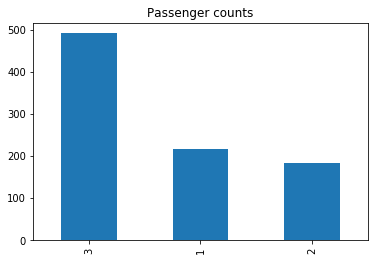

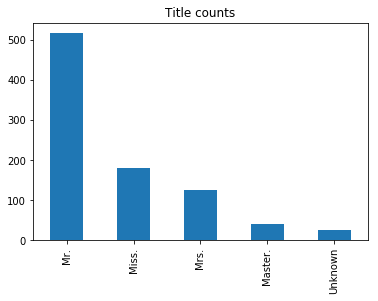

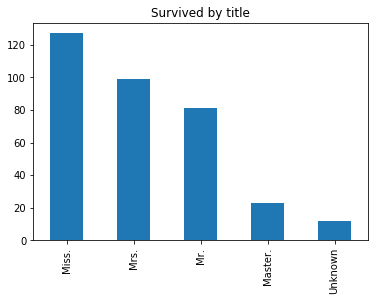

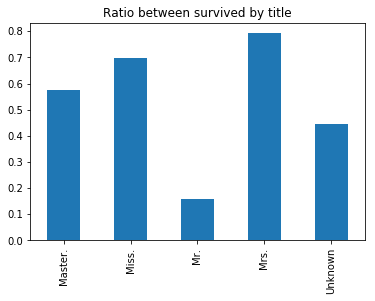

In [11]:
%matplotlib inline
plt.figure()
train_data_cleaned["Pclass"].value_counts().plot(kind="bar", title="Passenger counts")

plt.figure()
train_data_cleaned["Name"].value_counts().plot(kind="bar", title="Title counts")

plt.figure()
train_data_cleaned.loc[train["Survived"] == 1, "Name"].value_counts().plot(kind="bar", title="Survived by title")

plt.figure()
(train_data_cleaned.loc[train["Survived"] == 1, "Name"].value_counts() / train_data_cleaned["Name"].value_counts()).plot(kind="bar", title="Ratio between survived by title")


In [25]:
from sklearn.model_selection import train_test_split
#seems to be lucky split :(
train_X , test_X, train_y, test_y = train_test_split(train_data_cleaned, train["Survived"], random_state=26)

print(test_y.value_counts()/train_y.value_counts())


0    0.348894
1    0.310345
Name: Survived, dtype: float64


In [26]:
one_hot_X_train = one_hot_encoder.transform(encode_categorical(train_X[categorical_columns], categorical_columns, encoders))
one_hot_X_test = one_hot_encoder.transform(encode_categorical(test_X[categorical_columns], categorical_columns, encoders))

# train_X["Family"] = train_X["SibSp"] + train_X["Parch"]
# train_X = train_X.drop(["SibSp", "Parch"], axis=1)

# test_X["Family"] = test_X["SibSp"] + test_X["Parch"]
# test_X = test_X.drop(["SibSp", "Parch"], axis=1)

# print(train_X.head(10))

print("Shape of numeric columns of train and test {} {}".format(train_X[numeric_columns].shape, test_X[numeric_columns].shape))
print("Shape of encoded categorical cloumns of train and test {} {}".format(one_hot_X_train.shape, one_hot_X_test.shape))

train_X = np.concatenate([train_X[numeric_columns], one_hot_X_train.toarray()], axis=1);
test_X = np.concatenate([test_X[numeric_columns], one_hot_X_test.toarray()], axis=1)



print("Shape of numeric and categorical {} {}".format(train_X.shape, test_X.shape))



Shape of numeric columns of train and test (668, 4) (223, 4)
Shape of encoded categorical cloumns of train and test (668, 1129) (223, 1129)
Shape of numeric and categorical (668, 1133) (223, 1133)


In [27]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C=10)
model.fit(train_X, train_y)

def print_score(train, test):
    print("Train score is {}".format(train))
    print("Test score is {}".format(test))
    print("")

print("Logistic regression score:")
print_score(model.score(train_X, train_y), model.score(test_X, test_y))

Logistic regression score:
Train score is 0.9955089820359282
Test score is 0.8385650224215246



In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#tested with different n_estimators = 10 best
random_f_model = RandomForestClassifier(random_state=0)
random_f_model.fit(train_X, train_y)
print("Random forest score:")
print_score(random_f_model.score(train_X, train_y), random_f_model.score(test_X, test_y))

Random forest score:
Train score is 0.9790419161676647
Test score is 0.8295964125560538



In [29]:
one_hot_test_data = one_hot_encoder.transform(encode_categorical(test_data_cleaned_for_submission[categorical_columns], categorical_columns, encoders))

# Same score as having sibsp and parch columns
# test_data_cleaned_for_submission["Family"] = test_data_cleaned_for_submission["SibSp"] +test_data_cleaned_for_submission["Parch"]
# test_data_cleaned_for_submission= test_data_cleaned_for_submission.drop(["SibSp", "Parch"], axis=1)


test_data_processed = np.concatenate([test_data_cleaned_for_submission[numeric_columns], one_hot_test_data.toarray()], axis=1);

#prediction = random_f_model.predict(test_data_processed)
prediction = model.predict(test_data_processed)

def save(prediction):
    df = pd.DataFrame(data={"Survived": prediction}, index=submission_dataset["PassengerId"])
    df.to_csv("with_data_cleaning.csv")

save(prediction)